### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 5th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
# from scipy import optimize

## (1)

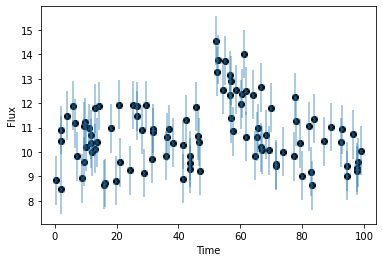

In [2]:
# 1) Read in hw5_data_1.npy. This is a (10 x 3) numpy array, containing some time-series measurements. 
# It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), 
# the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties 
# on the flux. Plot this data with the uncertainties.

data = np.load("../../homeworks/hw_data/hw5_data_1.npy")
time,flux,flux_sig = data[:,0],data[:,1],data[:,2]

plt.scatter(time,flux,c='k')
plt.errorbar(time, flux, yerr=flux_sig, ls=' ', marker='x',alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

## (2)

In [3]:
# 2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal 
# background level. This model can be described as:

# 𝑦=𝑏 , for  𝑡<𝑡0 
# 𝑦=𝑏+𝐴exp[−𝛼(𝑡−𝑡0)] , for  𝑡≥𝑡0 
# where  𝑏  is the background amplitude, 𝐴  is the burst amplitude,  𝑡0  is the burst epoch, and  𝛼  encodes 
# how rapidly the burst dies off.

# Code this burst model, and code a likelihood function for this data with the burst model. 
# Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now  𝑥  is time, 
# and the polynomial model is now the burst model.

# def burst(x,b,A,t0,alpha):
#     # x is t
#     y_mod=[]
#     for i in x:
#         if i<t0:
#             y_model = b
#         else:
#             y_model = b + A*np.exp(-alpha*(i-t0))
            
#         y_mod.append(y_model)
        
#     return np.array(y_mod)

def burst(x,b,A,t0,alpha):
    # x is t
    y_mod = np.full(len(x),0)
    
    idxes1 = np.where(np.array(x)<t0)[0]
    idxes2 = np.where(np.array(x)>=t0)[0]
    
    y_mod[idxes1] = b 
    y_mod[idxes2] = b + A*np.exp(-alpha*(np.array(x)[idxes2]-t0))
        
    return np.array(y_mod)
    
# look at 19-ish
def logL(theta): 
#     np.arrray of parameters
#     keep x 
    yfit = burst(x=time,b=theta[0],A=theta[1],t0=theta[2],alpha=np.exp(theta[3])) #np.exp(theta[3])
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(flux, yfit, flux_sig))
    


## (3)

In [4]:
# 3) Using one of the MCMC codes that we looked at in class (emcee, pymc3, PTMCMCSampler) perform a Bayesian analysis 
# that recovers an MCMC chain of posterior probability samples for the joint parameter space of  {𝑏,𝐴,𝑡0,𝛼} . 
# You must decide on how many samples are appropriate for running your MCMC. For your priors, make them  
# 𝑏∈Uniform[0,50] ,  𝐴∈Uniform[0,50] ,  𝑡0∈Uniform[0,100] , and  ln𝛼∈Uniform[−5,5] .

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import scipy.stats as stats

def logPrior(theta):
    
    prior_b = stats.uniform.pdf(theta[0], loc=0, scale=50)
    prior_A = stats.uniform.pdf(theta[1], loc=0, scale=50)
    prior_t0 = stats.uniform.pdf(theta[2], loc=0, scale=100)
    prior_lnalpha = stats.uniform.pdf(theta[3], loc=-5, scale=10) 
    
    return  np.log(prior_b * prior_A * prior_t0 * prior_lnalpha)

# dimension of parameter space
ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2) # this is just initializing with a value of 0.01**2

# intialize sampler
sampler = ptmcmc(ndim, logL, logPrior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False) #!!!!!!!!!!!! set this to true

# sampler for N steps
N = int(10e5) #10*5 increase by a factor of 10, from 10^4 to 10^5
x0 = np.array([10., 10., 45., -1.])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)  #SCAMweight & DEweight=0 would affect acceptance rate


Optional mpi4py package is not installed.  MPI support is not available.
Finished 0.10 percent in 8.170048 s Acceptance rate = 0.921

/var/folders/8_/cx8t3z6n4c9ftpn96__x7z5c0000gq/T/ipykernel_79031/3105792955.py:16: RuntimeWarning: divide by zero encountered in log
  return  np.log(prior_b * prior_A * prior_t0 * prior_lnalpha)


Finished 1.00 percent in 77.775973 s Acceptance rate = 0.235857Adding DE jump with weight 50
Finished 99.90 percent in 8410.933388 s Acceptance rate = 0.195551
Run Complete


In [195]:
# 11-ish
len(chain[brn::thin,0])+725

1405

## (4)

Taking every n = 12 samples based on ac length.
Burning first n = 24975 samples.


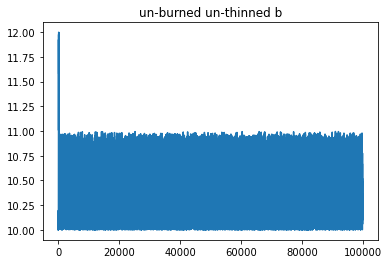

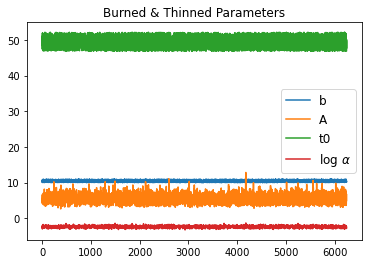

Text(0.5, 1.0, 'histogram of A')

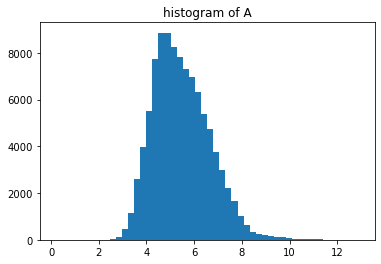

In [11]:
# 4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every 
# auto-correlation length. If you are left with a small number of samples after thinning then you may need to 
# run your MCMC for longer in (3).

# Load in the chain
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

import acor
thin = int(acor.acor(chain[:,0])[0])
brn = int(len(chain[:,0])*1/4)

print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(brn) + ' samples.')

b_downsampled = chain[brn::thin,0] #chain[:,0][brn:][::int(autocor)] 
A_downsampled = chain[brn::thin,1]
t0_downsampled = chain[brn::thin,2]
alpha_downsampled = chain[brn::thin,3]

plt.plot(chain[:,0]);plt.title('un-burned un-thinned b')
plt.show()
# plt.plot(b_downsampled);plt.title('b_downsampled')
# plt.show()
# plt.plot(A_downsampled);plt.title('A_downsampled')
# plt.show()
# plt.plot(t0_downsampled);plt.title('t0_downsampled')
# plt.show()
# plt.plot(alpha_downsampled);plt.title('alpha_downsampled')
# plt.show()

plt.title('Burned & Thinned Parameters')
plt.plot(b_downsampled,label='b')
plt.plot(A_downsampled,label='A')
plt.plot(t0_downsampled,label='t0')
plt.plot(alpha_downsampled,label=r'log $\alpha$')
plt.legend(loc='best',fontsize=12)
plt.show()

# check histogram instead
_=plt.hist(chain[:,1],bins=50)
plt.title('histogram of A')

# injected values
# plt.hlines(1.0, 0.0, 1500, color='k', lw=2, ls='dashed');
# plt.hlines(0.5, 0.0, 1500, color='k', lw=2, ls='dashed');

In [13]:
len(b_downsampled)

6244

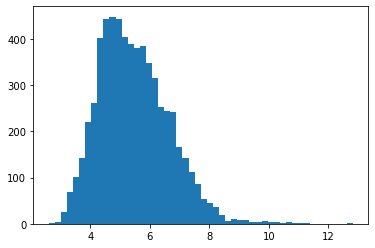

In [19]:
_=plt.hist(A_downsampled,bins=50)

## (5)

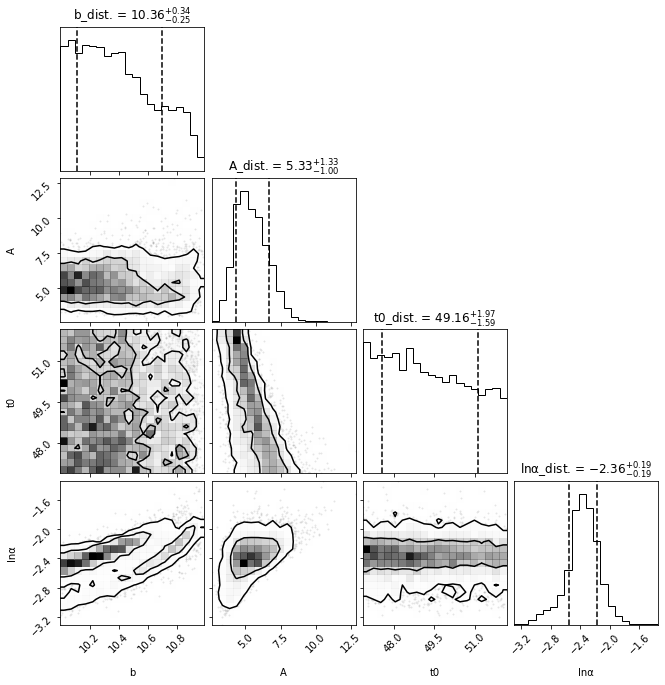

In [37]:
# 5) Make a corner plot of the  4 -D parameter space, with labels,  [68,95]%  credible levels and quantiles, 
# and titles.
import corner

combined = np.array([b_downsampled,A_downsampled,t0_downsampled,alpha_downsampled])
_=corner.corner(combined.T, quantiles=(0.16, 0.84), levels=(0.68,0.95), labels=['b','A','t0','lnα']
                    ,titles=['b_dist.','A_dist.','t0_dist.','lnα_dist.'],show_titles=True)

## (6)

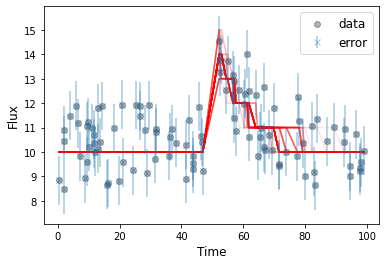

In [35]:
# 6) Now choose  100  samples randomly from your burned, thinned chain and plot the  100  corresponding burst 
# time-series on a figure along with the original data. You may want to choose a transparency for these  100  
# burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions 
# that are consistent with the data.

import random
from random import choices

idxs = choices(np.arange(0,len(b_downsampled),1),k=100) #np.random.randint(0,len(b_downsampled),size=100)

for i in idxs:
    
    b_random = b_downsampled[i] 
    A_random = A_downsampled[i] 
    t0_random = t0_downsampled[i] 
    alpha_random = alpha_downsampled[i] 
    burst_flux = burst(time,b_random,A_random,t0_random,np.exp(alpha_random))
    plt.plot(time,burst_flux,c='red',alpha=0.1)

plt.scatter(time,flux,c='k',label='data',alpha=0.3)
plt.errorbar(time, flux, yerr=flux_sig, ls=' ', marker='x',alpha=0.4,label='error')
plt.xlabel('Time',fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.legend(fontsize=12)
plt.show()

## (7)

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

In [38]:
import dynesty 

# Define the dimensionality of our problem.
ndim = 4

def gauss(x,b,A,t0,sig_w):
    # x is time
    y_mod = b + A*np.exp(-((np.array(x)-t0)**2) / (2*sig_w**2))
        
    return np.array(y_mod)
    
def loglike(theta): 

    yfit = gauss(x=time,b=theta[0],A=theta[1],t0=theta[2],sig_w=np.exp(theta[3]))
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(flux, yfit, flux_sig))

def ptform(u):
    params = u.copy()

    params[0] = u[0]*50.
    params[1] = u[1]*50.
    params[2] = u[2]*100.
    params[3] = 2. * (2. * u[3] - 1.)

    return  params

In [39]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

iter: 7958 | +500 | bound: 33 | nc: 1 | ncall: 41911 | eff(%): 20.181 | loglstar:   -inf < -144.334 <    inf | logz: -159.522 +/-  0.245 | dlogz:  0.001 >  0.509                                     

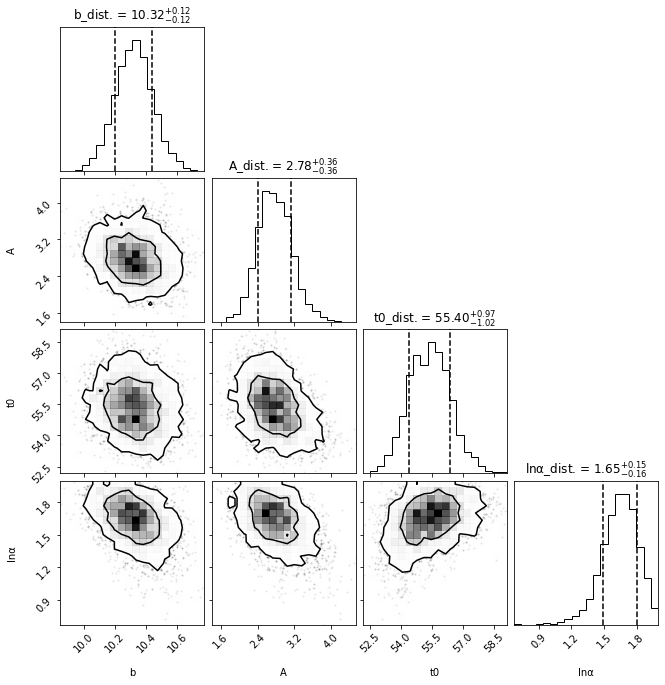

In [40]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)


_=corner.corner(samples_equal, quantiles=(0.16, 0.84), levels=(0.68,0.95), labels=['b','A','t0','lnα']
                    ,titles=['b_dist.','A_dist.','t0_dist.','lnα_dist.'],show_titles=True)